# Enviornment Check 

In [59]:
import sys
from pathlib import Path
import os 
from datetime import datetime
os.chdir(Path.cwd().parent)
sys.version


'3.8.6 (v3.8.6:db455296be, Sep 23 2020, 13:31:39) \n[Clang 6.0 (clang-600.0.57)]'

In [2]:
!pip list

Package                  Version
------------------------ --------
anyio                    3.6.2
appnope                  0.1.3
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
arrow                    1.2.3
astor                    0.8.1
asttokens                2.2.1
attrs                    22.2.0
autograd                 1.5
autograd-gamma           0.5.0
backcall                 0.2.0
beautifulsoup4           4.11.2
bleach                   6.0.0
cffi                     1.15.1
cloudpickle              2.2.1
comm                     0.1.2
contourpy                1.0.7
cpca                     0.5.5
cycler                   0.11.0
debugpy                  1.6.6
decorator                5.1.1
defusedxml               0.7.1
executing                1.2.0
fastjsonschema           2.16.2
fonttools                4.38.0
formulaic                0.5.2
fqdn                     1.5.1
future                   0.18.3
graphlib-backport        1.0.3
idna                     3.

# Package and Data Import

In [78]:
import numpy as np
from src import DataImport
import matplotlib.pyplot as plt
from src import Models
import shap
import pandas as pd 
import xgboost
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, cross_val_score
from src import Evaluate

test_size = 0.3
df = DataImport.data_reader_by_us(bio=False)
df = df.loc[df['age']>=50]
domains = DataImport.domain_dict()
var_dict = DataImport.variable_dict()
var_dict['ZincomeT'] = 'Income'
var_dict['ZwealthT'] = 'Wealth'
var_dict['rocc'] = 'Lower Occupational Status'


df.shape

(13575, 72)

In [79]:
df['age'].describe()

count    13575.000000
mean        68.729945
std          9.869541
min         50.000000
25%         61.000000
50%         68.000000
75%         76.000000
max        104.000000
Name: age, dtype: float64

In [80]:
random_state = 87785

# Model Fit 

## Model Performance Comparison

for model_selection in ['xgb','lgb']:
    print(f'\n{model_selection}')
    model = Models.Model_fixed_test_size(data=dfMort, test_size=0.3,domain_list=domains['all'], model=model_selection,train_subset_size=1, order=0, y_colname='death')
    evas = Evaluate.metric(model)
    print(f'imv={evas.imv},\nroc-auc={evas.auc_score},\npr-auc={evas.pr_auc},\nf1={evas.pr_f1},\nefron_r2={evas.efron_rsquare},\nffc_r2={evas.ffc_r2},\nIP={evas.pr_no_skill}')
    


In [81]:
print(f'today is {datetime.today()}')
for model_selection in ['xgb','lgb']:
    print(f'\n{model_selection}')
    model = Models.Model_fixed_test_size(data=df, test_size=0.3,domain_list=domains['all'], model=model_selection,train_subset_size=1, order=0, y_colname='death',random_state=random_state)
    evas = Evaluate.metric(model)
    print(f'imv={evas.imv},\nroc-auc={evas.auc_score},\npr-auc={evas.pr_auc},\nf1={evas.pr_f1},\nefron_r2={evas.efron_rsquare},\nffc_r2={evas.ffc_r2},\nIP={evas.pr_no_skill}')
    del model, evas


today is 2023-03-02 21:02:36.667884

xgb
seed is 87785
imv=0.13950427508197336,
roc-auc=0.7979042175022075,
pr-auc=0.6458229924593557,
f1=0.5542168674698795,
efron_r2=0.21347014251285568,
ffc_r2=0.5167290427127114,
IP=0.2933066722795201

lgb
seed is 87785
imv=0.2038370443560898,
roc-auc=0.8246432517789302,
pr-auc=0.6866060054221803,
f1=0.5848540145985401,
efron_r2=0.28975000906425197,
ffc_r2=0.5635980125034004,
IP=0.2933066722795201


Thus we select lgb as the 'best model' to fit shap 

## Cross Validation 

# SHAP Calculation

model = Models.Model_fixed_test_size(data=df, test_size=0.3,domain_list=domains['all'], model='xgb',train_subset_size=1, order=0, y_colname='death')
evas = Evaluate.metric(model)
print(f'imv={evas.imv},\nroc-auc={evas.auc_score},\npr-auc={evas.pr_auc},\nf1={evas.pr_f1},\nefron_r2={evas.efron_rsquare},\nffc_r2={evas.ffc_r2},\nIP={evas.pr_no_skill}')
    

In [82]:
#fit the model again to confirm the model performance 
model = Models.Model_fixed_test_size(data=df, test_size=0.3,domain_list=domains['all'], model='lgb',train_subset_size=1, order=0, y_colname='death',random_state=random_state)
evas = Evaluate.metric(model)
print(f'imv={evas.imv},\nroc-auc={evas.auc_score},\npr-auc={evas.pr_auc},\nf1={evas.pr_f1},\nefron_r2={evas.efron_rsquare},\nffc_r2={evas.ffc_r2},\nIP={evas.pr_no_skill}')


seed is 87785
imv=0.2038370443560898,
roc-auc=0.8246432517789302,
pr-auc=0.6866060054221803,
f1=0.5848540145985401,
efron_r2=0.28975000906425197,
ffc_r2=0.5635980125034004,
IP=0.2933066722795201


In [83]:
explainer = shap.TreeExplainer(model.model)
shap_values_test = explainer(model.X_test)

In [84]:
# store the mean absolute shap value for each variable in a dictionary
if len(shap_values_test.shape)==3:
    shap_values_test.values=shap_values_test.values[:,:,1]
shap_dic = {}
i = 0
while i < shap_values_test.values.shape[1]:
    sum_shap = 0
    for m in shap_values_test.values[:, i]:
        sum_shap += np.abs(m)
    shap_dic[shap_values_test.feature_names[i]] = sum_shap / shap_values_test.values.shape[0]
    i += 1

In [85]:
shap_values_test.shape

(4073, 61)

# Plot

## shap rank bar plot 

In [ ]:
color_blue = '#001C5B'
# summary bar plot
max_display = 61
fontsize_ticks = 20
fontsize_labels = 21
sum_features = 'Sum of ' + str(61 - max_display) + ' other features'
shap.plots.bar(shap_values_test, show=False, max_display=max_display)
fig = plt.gcf()
# 26，19
fig.set_figheight(26)
fig.set_figwidth(19)
# fig.subplots_adjust(left=0.4, top=0.99, bottom=0.04,right=0.95)
fig.subplots_adjust(left=0.3, top=0.99, bottom=0.04, right=0.95)

ax = plt.gca()
var_dict[sum_features] = sum_features

ylabels = [var_dict[y_tick.get_text()] for y_tick in ax.get_yticklabels()]
ax.set_yticklabels(ylabels)
ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
# xax.set_ylabel('Input Factors', fontsize=fontsize_labels)
ax.set_xlabel('mean(|SHAP Value|)', fontsize=fontsize_labels)
fig.tight_layout()
# plt.savefig(Path.cwd()/'graphs/mean_shap_top10.pdf')
# plt.savefig(Path.cwd() / 'graphs/mean_shap_all.pdf')

plt.show()

## top 10 scatter plot 

firstly, calculate the rank list in the format `[['feature_name',mean(abs(shap))]]`

In [87]:
abs_rank_lst=[]
for i in range(shap_values_test.values.shape[1]):
    importance = sum(abs(shap_values_test.values[:,i]))/shap_values_test.values.shape[0]
    feature_name= shap_values_test.feature_names[i]
    abs_rank_lst.append([feature_name,importance])

abs_rank_lst=sorted(abs_rank_lst, key=lambda list:list[1],reverse=True)    

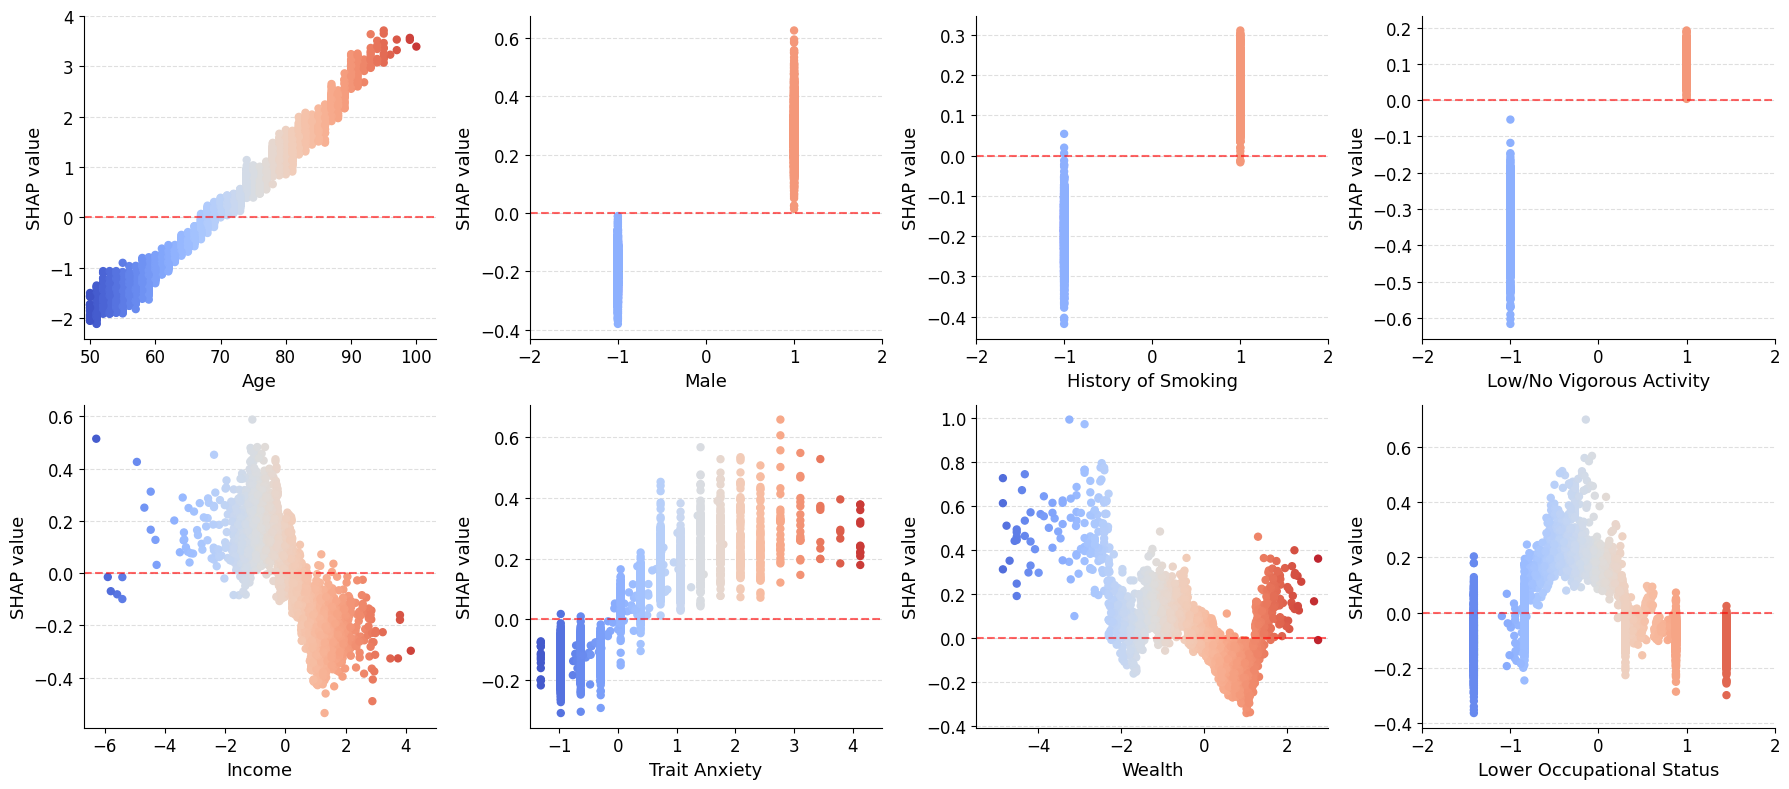

In [95]:
variable_to_display = [x[0] for x in abs_rank_lst if round(x[1],2)>=0.1]

lim_dic={"age":[49,103],"ZincomeT":[-6.7, 5],"ZwealthT":[-5.5, 3],'Zanxiety':[-1.5, 4.5],'Zperceivedconstraints':[-1.5, 3.5],'Zconscientiousness':[-2.5, 5]}


i = 0
fontsize_ticks = 12
fontsize_labels = 13
figure, axis = plt.subplots(2, round((len(variable_to_display)+0.1)/2))
figure.subplots_adjust(left=0.08, top=0.95, bottom=0.08, right=0.95)
figure.set_figheight(8)
figure.set_figwidth(18)

for (m, n), subplot in np.ndenumerate(axis):
    if i<len(variable_to_display):
        var = variable_to_display[i]
        ind = shap_values_test.feature_names.index(var)
        shap_value = shap_values_test.values[:, ind]
        value = shap_values_test.data[:, ind]
        if var in lim_dic:
            lim_upper, lim_lower = lim_dic[var][1],lim_dic[var][0]
        else:
            lim_upper, lim_lower = int(value.max()) + 1, int(value.min()) - 1

        axis[m, n].scatter(value, shap_value, c=value, s=[25] * len(value), cmap='coolwarm', norm=plt.Normalize(vmin=lim_lower, vmax=lim_upper))
        axis[m, n].set_xlim(lim_lower, lim_upper)
        axis[m, n].grid(axis='y', alpha=0.4, linestyle='dashed')
        axis[m, n].axhline(y=0, color='red', linestyle='--', alpha=0.6)
        axis[m, n].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
        axis[m, n].spines['top'].set_visible(False)
        axis[m, n].spines['right'].set_visible(False)
        axis[m, n].set_ylabel('SHAP value', fontsize=fontsize_labels)
        axis[m, n].set_xlabel(var_dict[var], fontsize=fontsize_labels)
        axis[m, n].set_axisbelow(True)

        i += 1
figure.tight_layout()
#plt.show()
plt.savefig(Path.cwd()/f'OX_Thesis/graphs/shap_scatter_top_seed_{random_state}.pdf')

## Summary Shap Plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


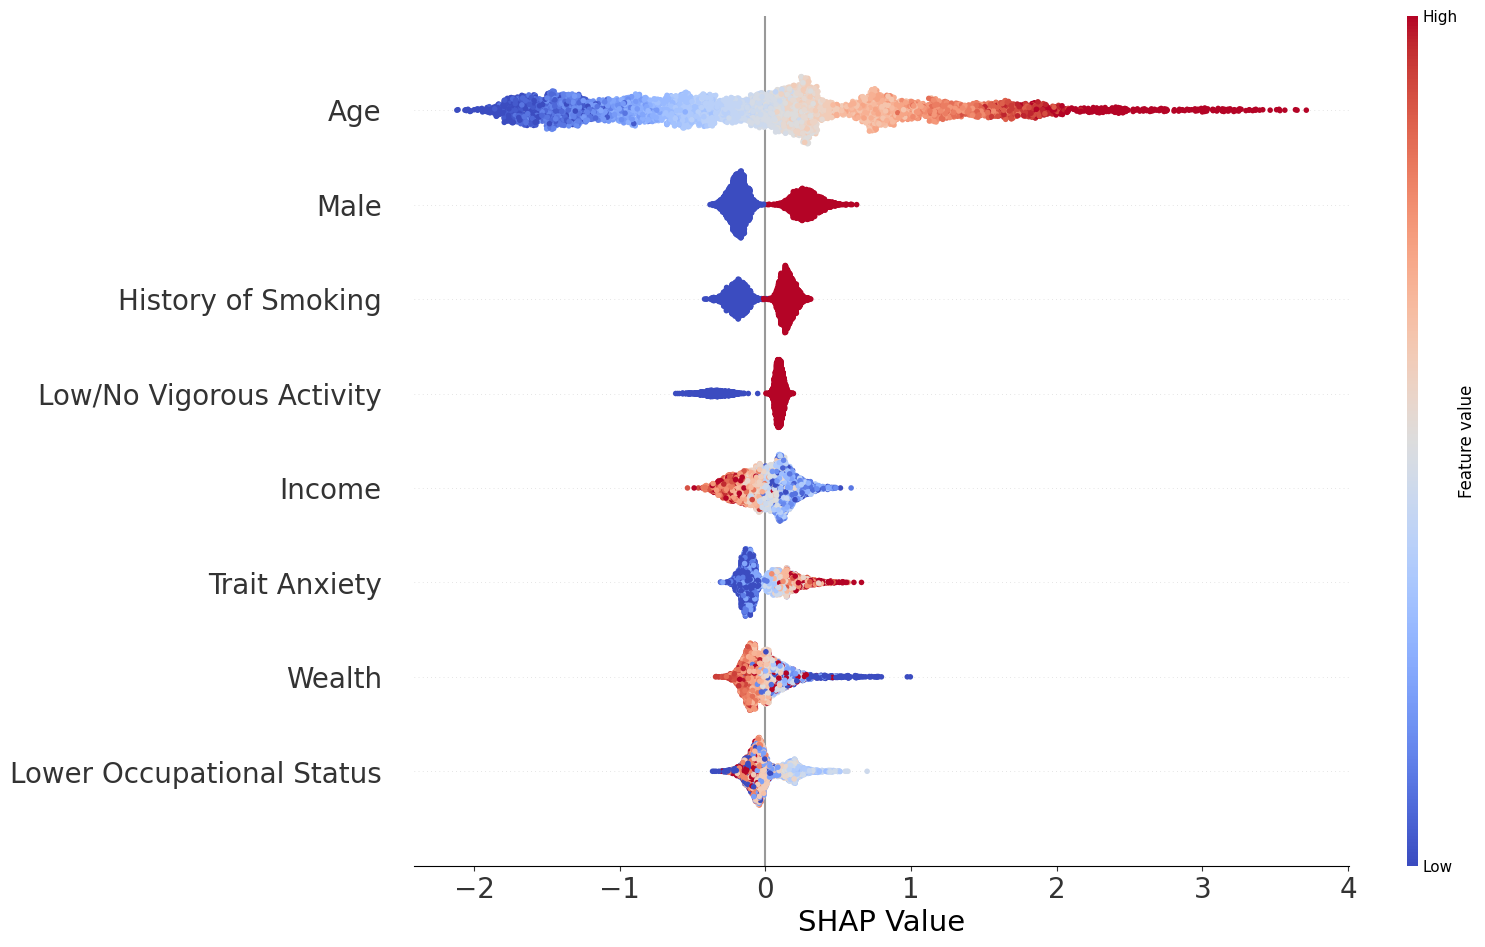

In [90]:
# 
fontsize_ticks = 20
fontsize_labels = 21
shap.summary_plot(shap_values_test, model.X_test, show=False, max_display=len(variable_to_display), cmap='coolwarm')
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(16)
fig.subplots_adjust(left=0.28, top=0.95, right=1.01, bottom=0.1)

ax = plt.gca()
plt.rc('legend', fontsize=25)
ax.set_xlabel('SHAP Value', fontsize=fontsize_labels)
ylabels = [var_dict[y_tick.get_text()] for y_tick in ax.get_yticklabels()]
ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax.set_yticklabels(ylabels)

# plt.savefig(Path.cwd() / 'graphs/summary_shap.pdf')
plt.show()
